# Fiddler Quick Start Guide for Explainability (XAI) with Surrogate Models

Fiddler is not only a powerful observability tool for monitoring the health of your ML models in production but also an explainability tool to peak into your black box models. With the ability to **point explain** and **global explain** your model, Fiddler provides powerful visualizations that can explain your model's behavior. 


---


You can start exploring Fiddler's XAI capabilities by following these five quick steps:

1. Connect to Fiddler
2. Upload a baseline dataset
3. Add your model details to Fiddler
4. Either upload a model artifact or use Fiddler generated surrogate model
5. Publish Production Events
6. Get insights

**Don't have a Fiddler account? [Sign-up for a 14-day free trial](https://www.fiddler.ai/trial?utm_source=fiddler_docs&utm_medium=referral).**

## 0. Imports

In [ ]:
!pip install -q fiddler-client

import numpy as np
import pandas as pd
import fiddler as fdl
import time as time

print(f"Running client version {fdl.__version__}")

## 1. Connect to Fiddler

Before you can register your model with Fiddler, you'll need to connect using our API client.


---


**We need a few pieces of information to get started.**
1. The URL you're using to connect to Fiddler

In [ ]:
URL = '' # Make sure to include the full URL (including https://).

In [ ]:
ORG_ID = ''
AUTH_TOKEN = ''

2. Your organization ID
3. Your authorization token

Both of these can be found by clicking the URL you entered and navigating to the **Settings** page of your Fiddler environment.

Now just run the following code block to connect to the Fiddler API!

In [ ]:
client = fdl.FiddlerApi(
    url=URL,
    org_id=ORG_ID,
    auth_token=AUTH_TOKEN
)

Once you connect, you can create a new project by specifying a unique project ID in the client's `create_project` function.

In [ ]:
PROJECT_ID = 'quickstart_surrogate_xai'

client.create_project(PROJECT_ID)

You should now be able to see the newly created project on the UI.

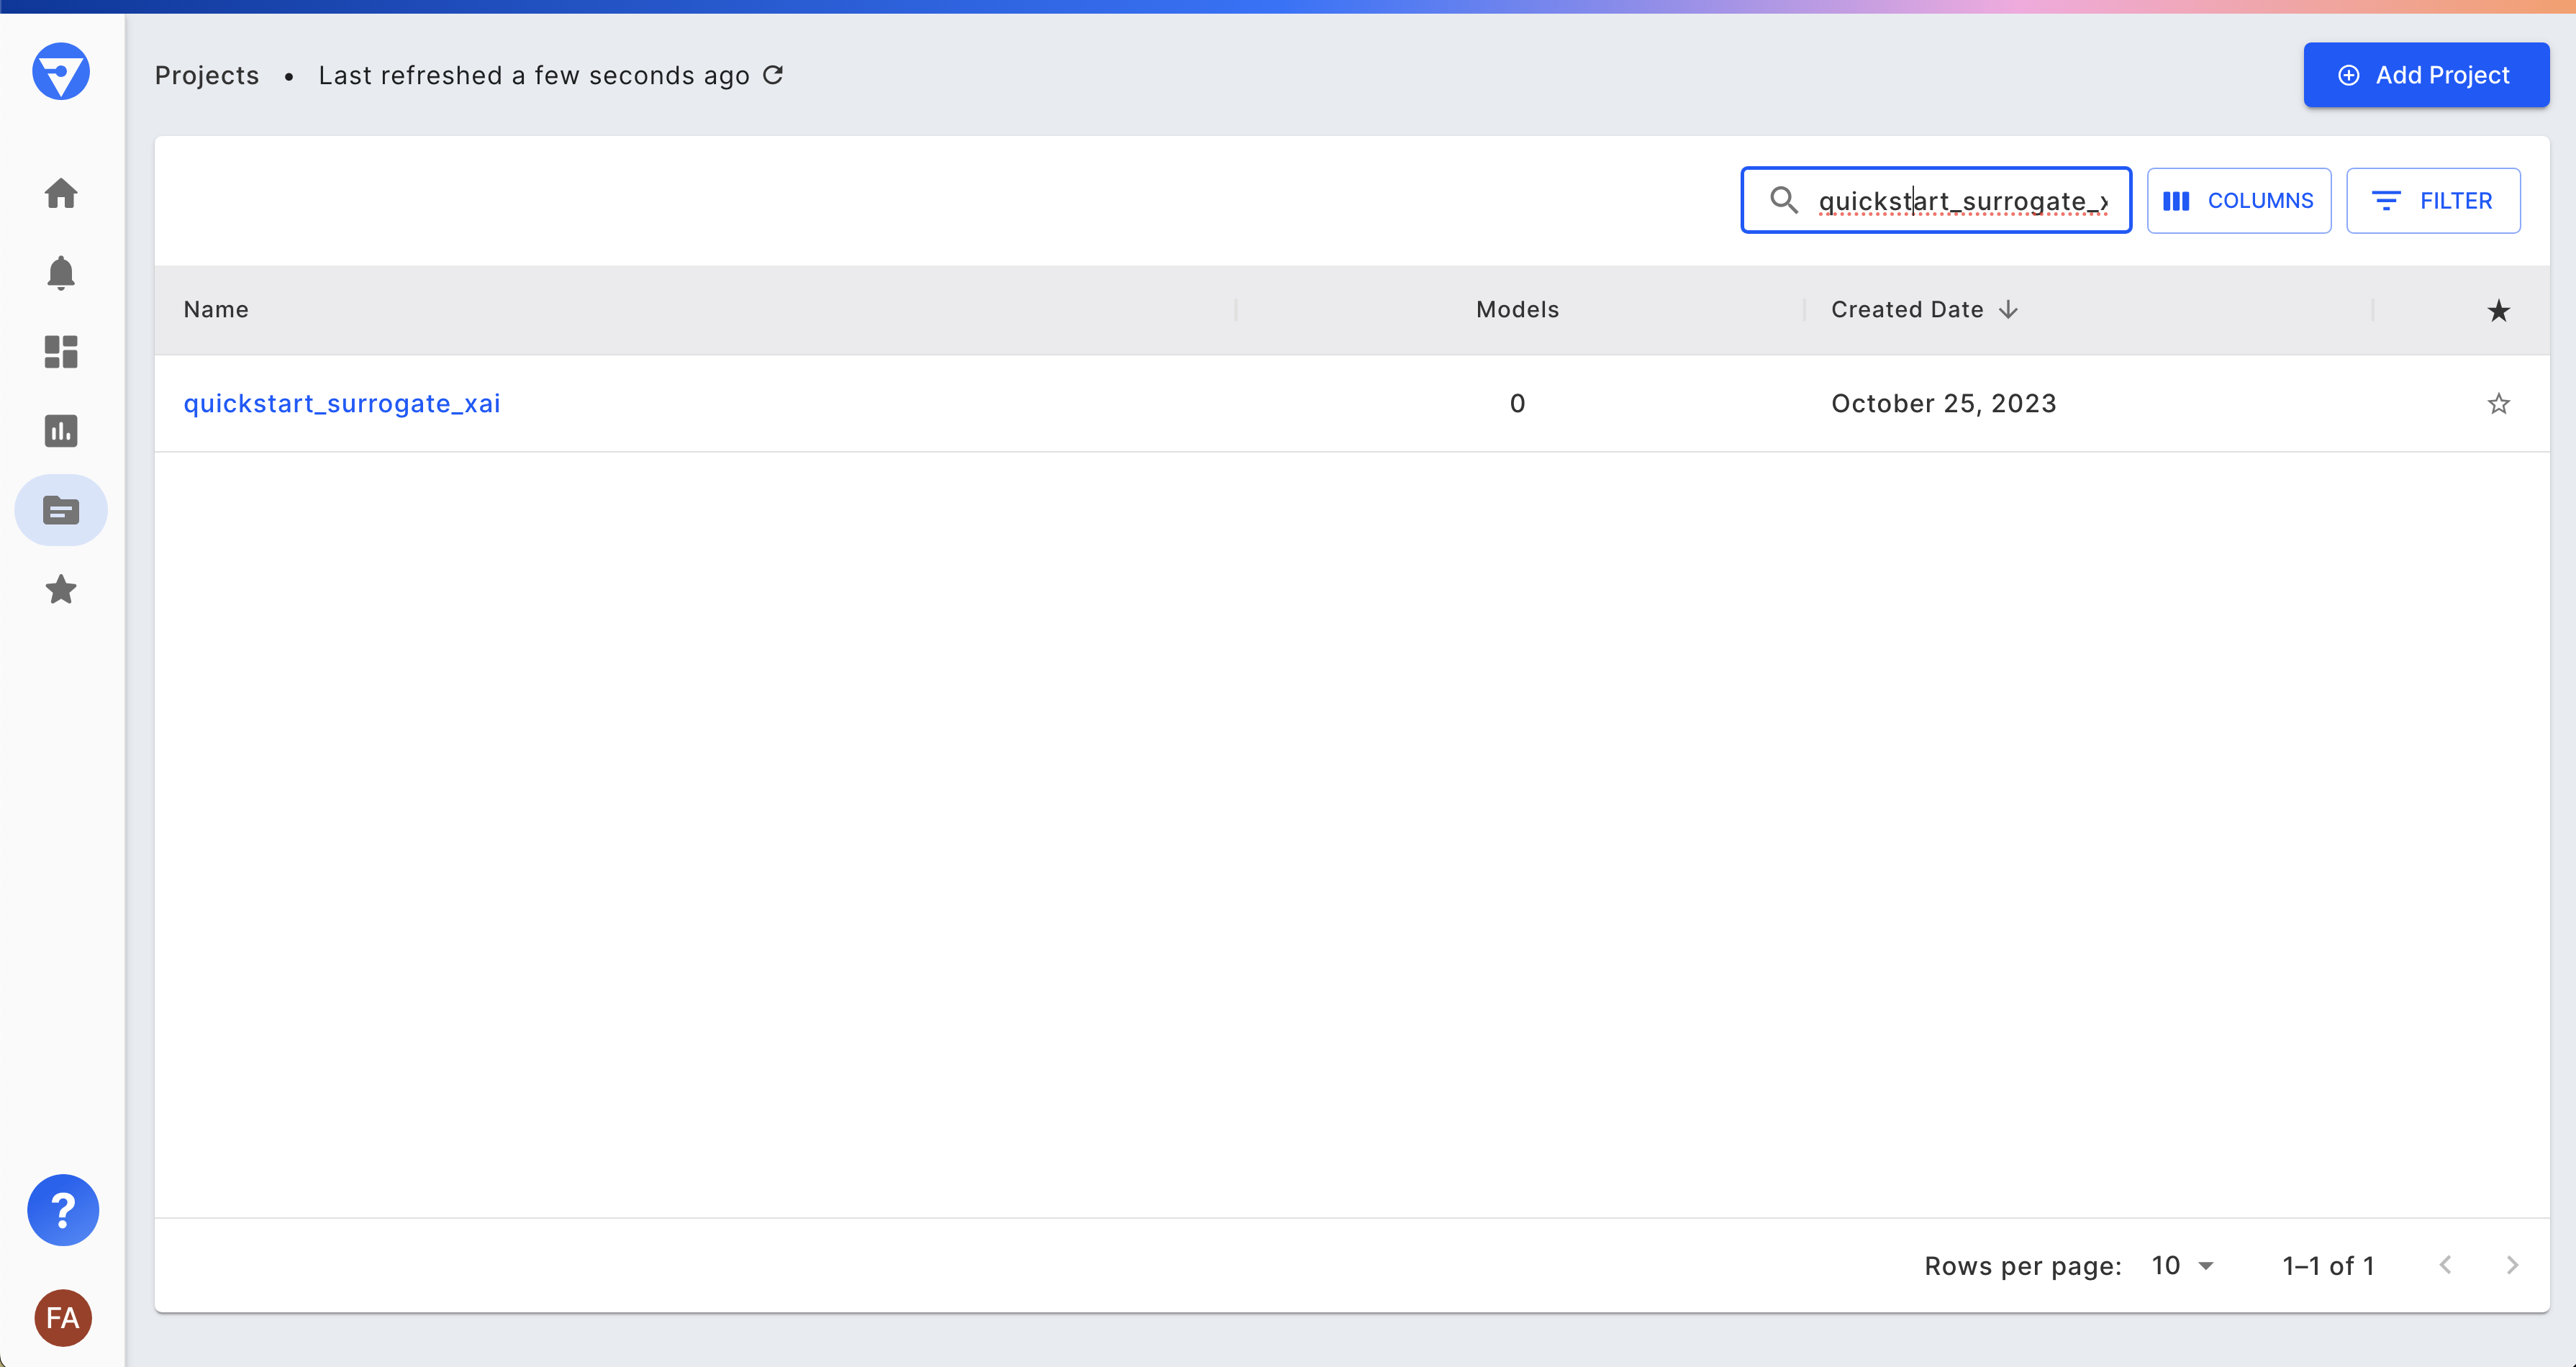

## 2. Upload a baseline dataset

In this example, we'll be considering the case where we're a bank and we have **a model that predicts churn for our customers**.  
We want to explain our model's predictions and **understand the features that impact model predictions** the most.
  
In order to get explainability insights, **Fiddler needs to fiddle with your model**. To do so, we need to add your model details. This includes information about the data used by your model. So, we first start with uploading a small sample of data that can serve as a baseline.


---


*For more information on how to design a baseline dataset, [click here](https://docs.fiddler.ai/pages/user-guide/data-science-concepts/monitoring/designing-a-baseline-dataset/).*

In [ ]:
PATH_TO_BASELINE_CSV = 'https://raw.githubusercontent.com/fiddler-labs/fiddler-examples/main/quickstart/data/churn_baseline.csv'

baseline_df = pd.read_csv(PATH_TO_BASELINE_CSV)
baseline_df

Fiddler uses this baseline dataset to keep track of important information about your data.
  
This includes **data types**, **data ranges**, and **unique values** for categorical variables.

---

You can construct a `DatasetInfo` object to be used as **a schema for keeping track of this information** by running the following code block.

In [ ]:
dataset_info = fdl.DatasetInfo.from_dataframe(baseline_df, max_inferred_cardinality=100)
dataset_info

Then use the client's `upload_dataset` function to send this information to Fiddler!
  
*Just include:*
1. A unique dataset ID
2. The baseline dataset as a pandas DataFrame
3. The `DatasetInfo` object you just created

In [ ]:
DATASET_ID = 'churn_data'

client.upload_dataset(
    project_id=PROJECT_ID,
    dataset_id=DATASET_ID,
    dataset={
        'baseline': baseline_df
    },
    info=dataset_info
)

If you click on your project in the Fiddler UI, you should now be able to see the newly onboarded dataset.

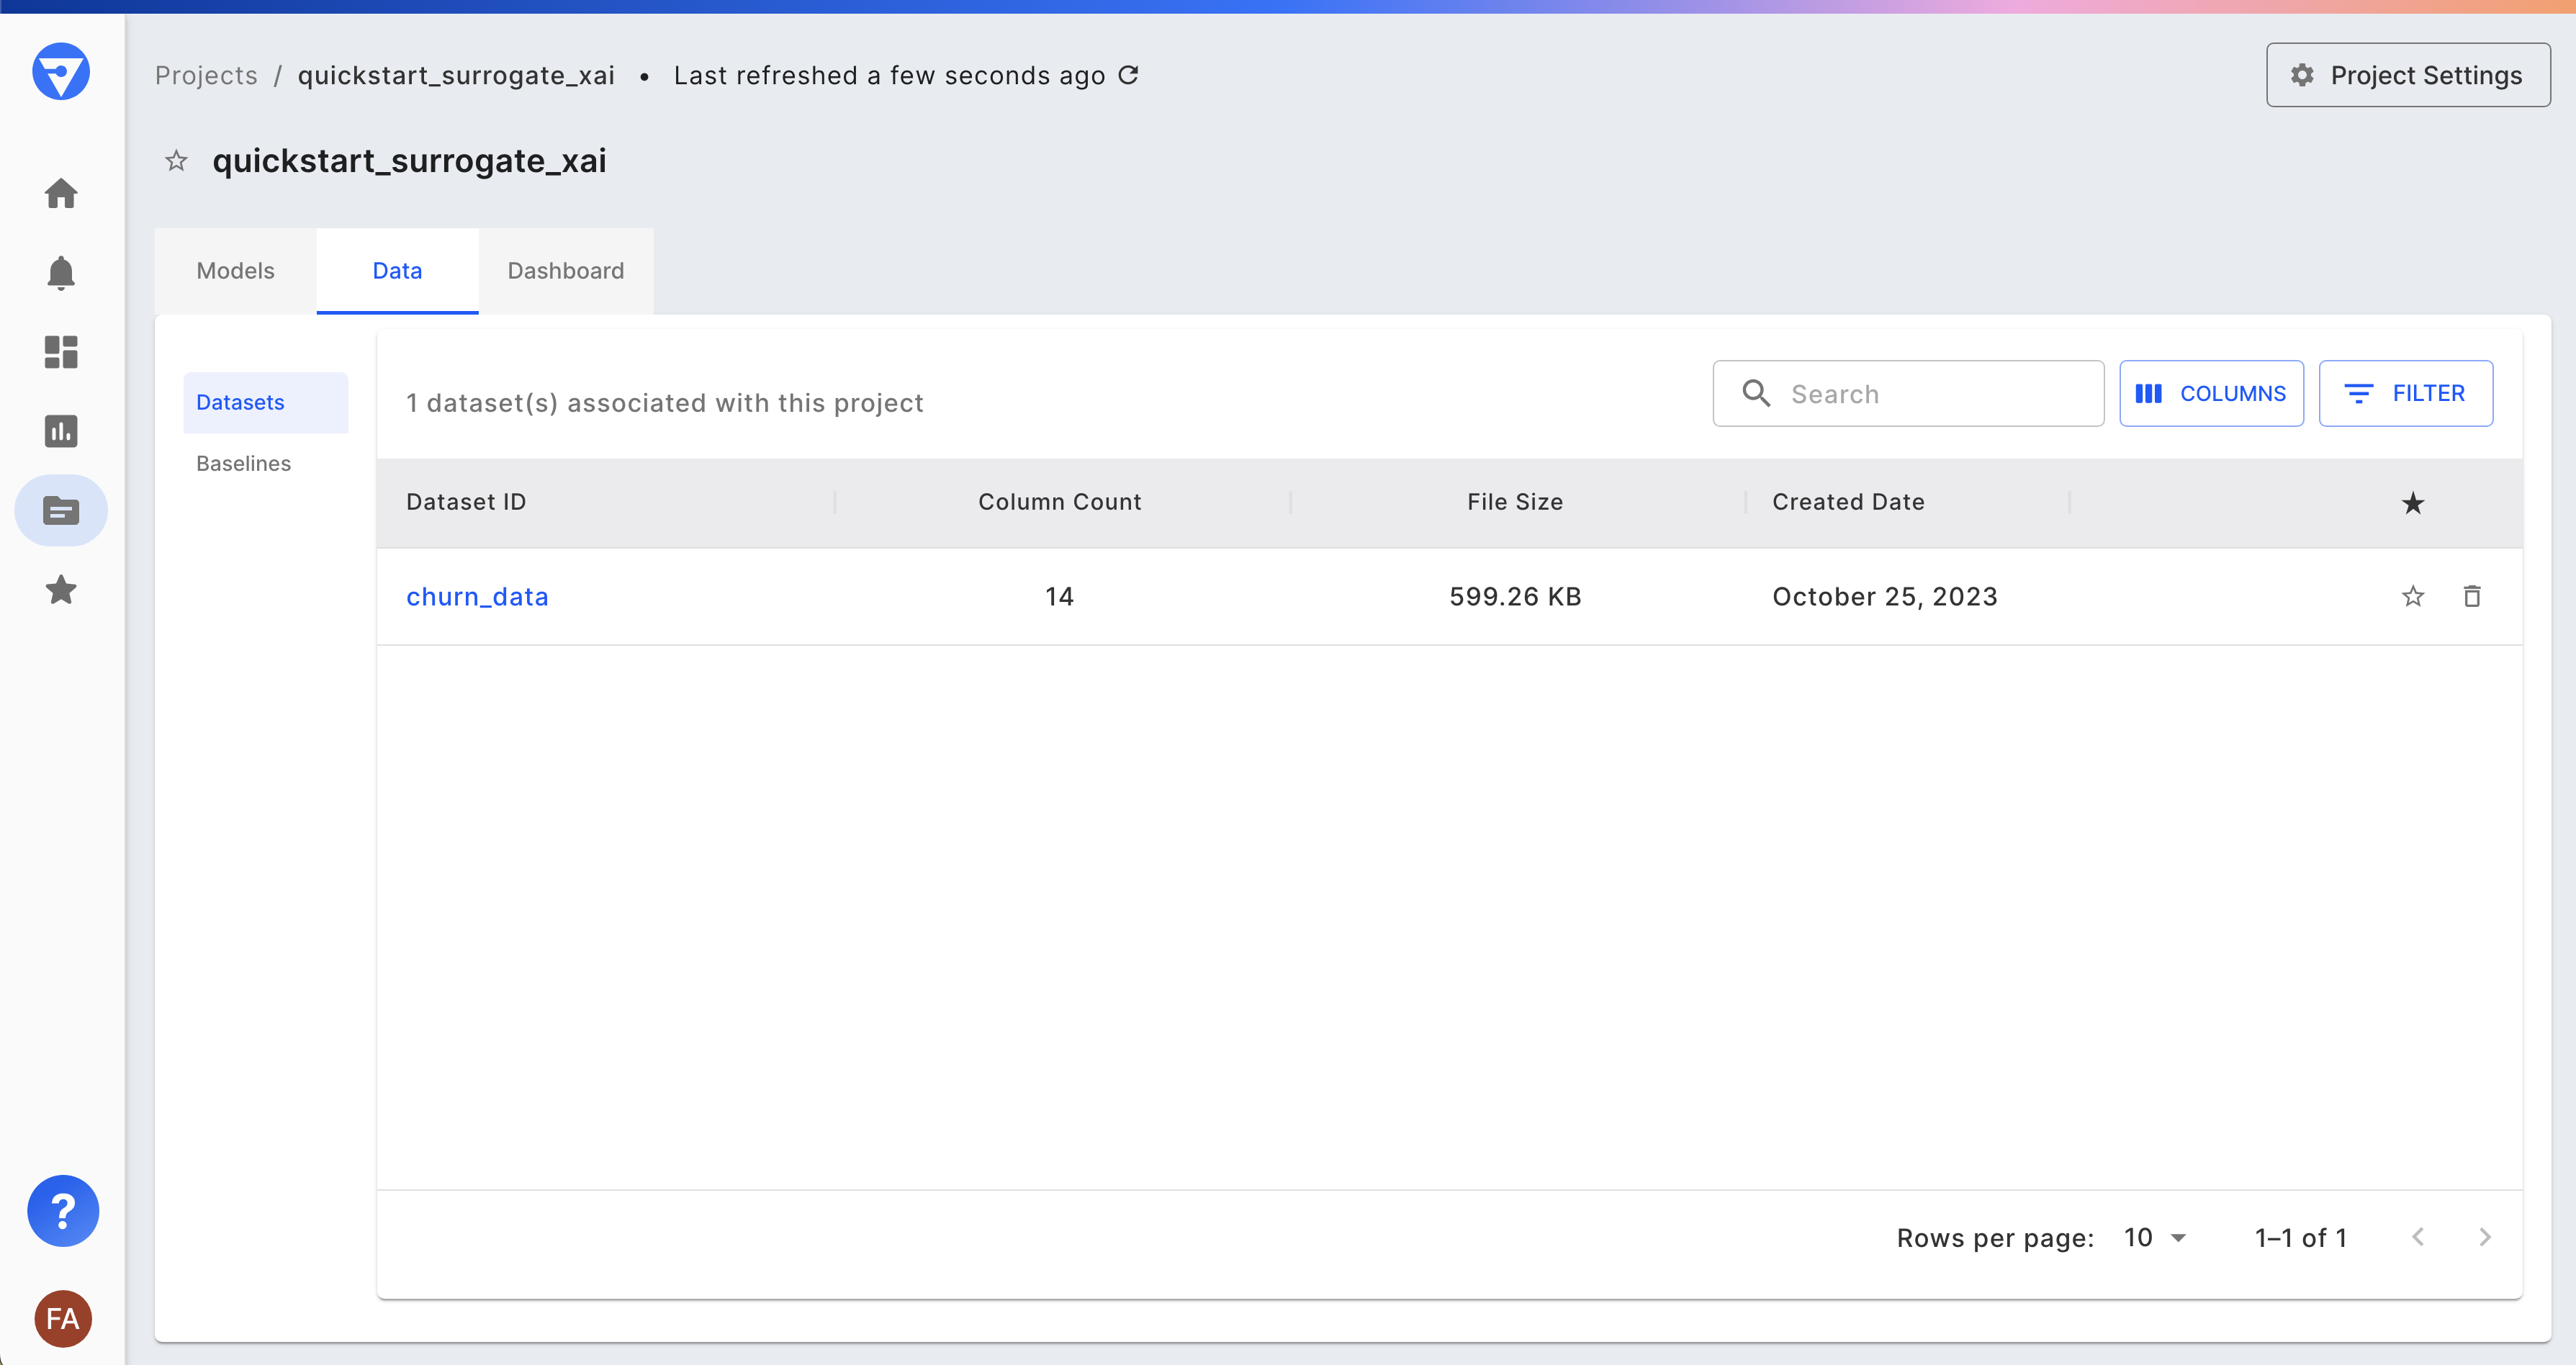

## 3. Add information about your model

Now it's time to add details about your model with Fiddler. We do so by first creating a **ModelInfo Object** that helps Fiddler understand **how your model operates**.
  
*Just include:*
1. The **task** your model is performing (regression, binary classification, etc.)
2. The **target** (ground truth) column
3. The **output** (prediction) column
4. The **feature** columns
5. Any **metadata** columns
6. Any **decision** columns (these measures the direct business decisions made as result of the model's prediction)


In [ ]:
# Specify task
model_task = 'binary'

if model_task == 'regression':
    model_task = fdl.ModelTask.REGRESSION
    
elif model_task == 'binary':
    model_task = fdl.ModelTask.BINARY_CLASSIFICATION

elif model_task == 'multiclass':
    model_task = fdl.ModelTask.MULTICLASS_CLASSIFICATION

    
# Specify column types
target = 'churn'
outputs = ['predicted_churn']
decision_cols = ['decision']
features = ['geography', 'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']
    
# Generate ModelInfo
model_info = fdl.ModelInfo.from_dataset_info(
    dataset_info=dataset_info,
    dataset_id=DATASET_ID,
    model_task=model_task,
    target=target,
    categorical_target_class_details='yes',
    outputs=outputs,
    decision_cols=decision_cols,
    features=features
)
model_info

After ModelInfo object is created to save your model information, use the client's *add_model* call to add the generated details about your model. 

**Note:** You will need to specify a unique model ID.

In [ ]:
MODEL_ID = 'churn_classifier'

client.add_model(
    project_id=PROJECT_ID,
    dataset_id=DATASET_ID,
    model_id=MODEL_ID,
    model_info=model_info
)

On the project page, you should now be able to see the newly created model. Notice how without uploading a model artifact or creating surrogate model, you can only explore monitoring capabilities.

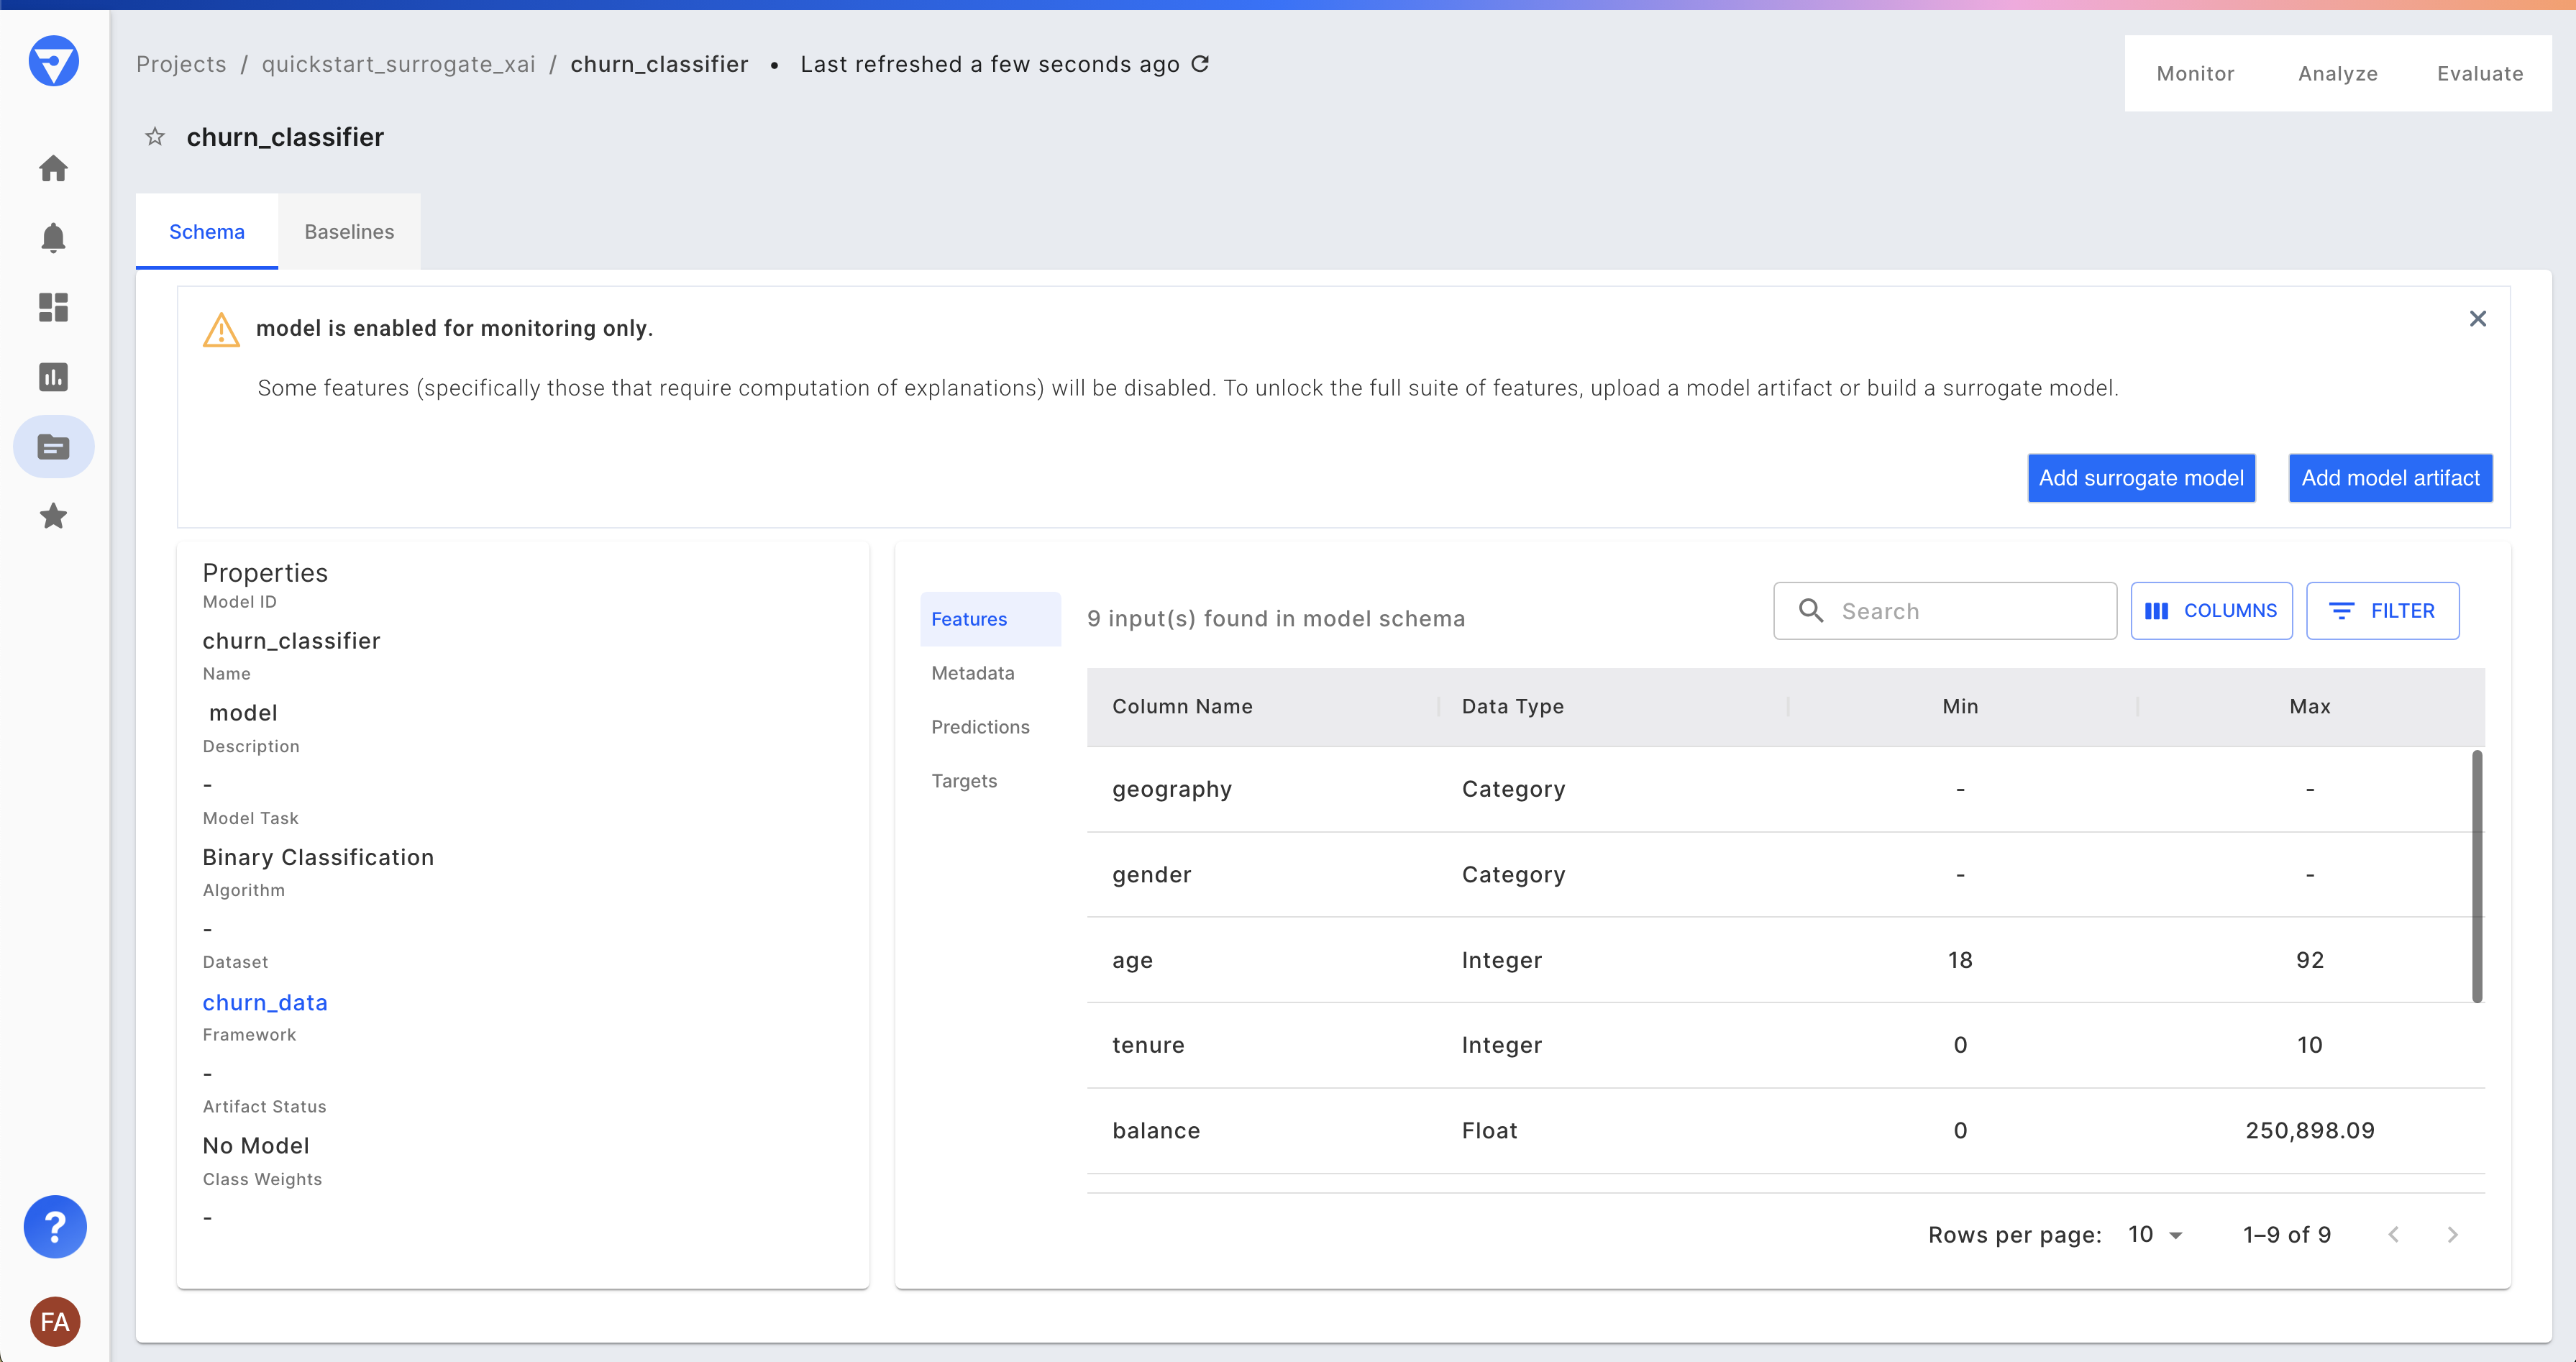

## 4. Either upload your own model or generate a surrogate model

With the above step, your model is added to Fiddler which means that for a given *project_id*, your given *model_id* now holds *ModelInfo* about the model you care about. 

In order to be able to run predictions for explainability analysis, however, you will need to upload your model file. If you just want to explore the XAI capabilities without providing your model to Fiddler, you can also generate a surrogate model which tries to mimic your model based on the details provided. 

Let's instruct Fiddler to generate a surrogate model based on the information (ModelInfo) provided above.

In [ ]:
client.add_model_surrogate(
    project_id=PROJECT_ID,
    model_id=MODEL_ID
)

Notice that our model schema page now lists our *Artifact Status* as "Surrogate" and we now see feature impact scores for our model.

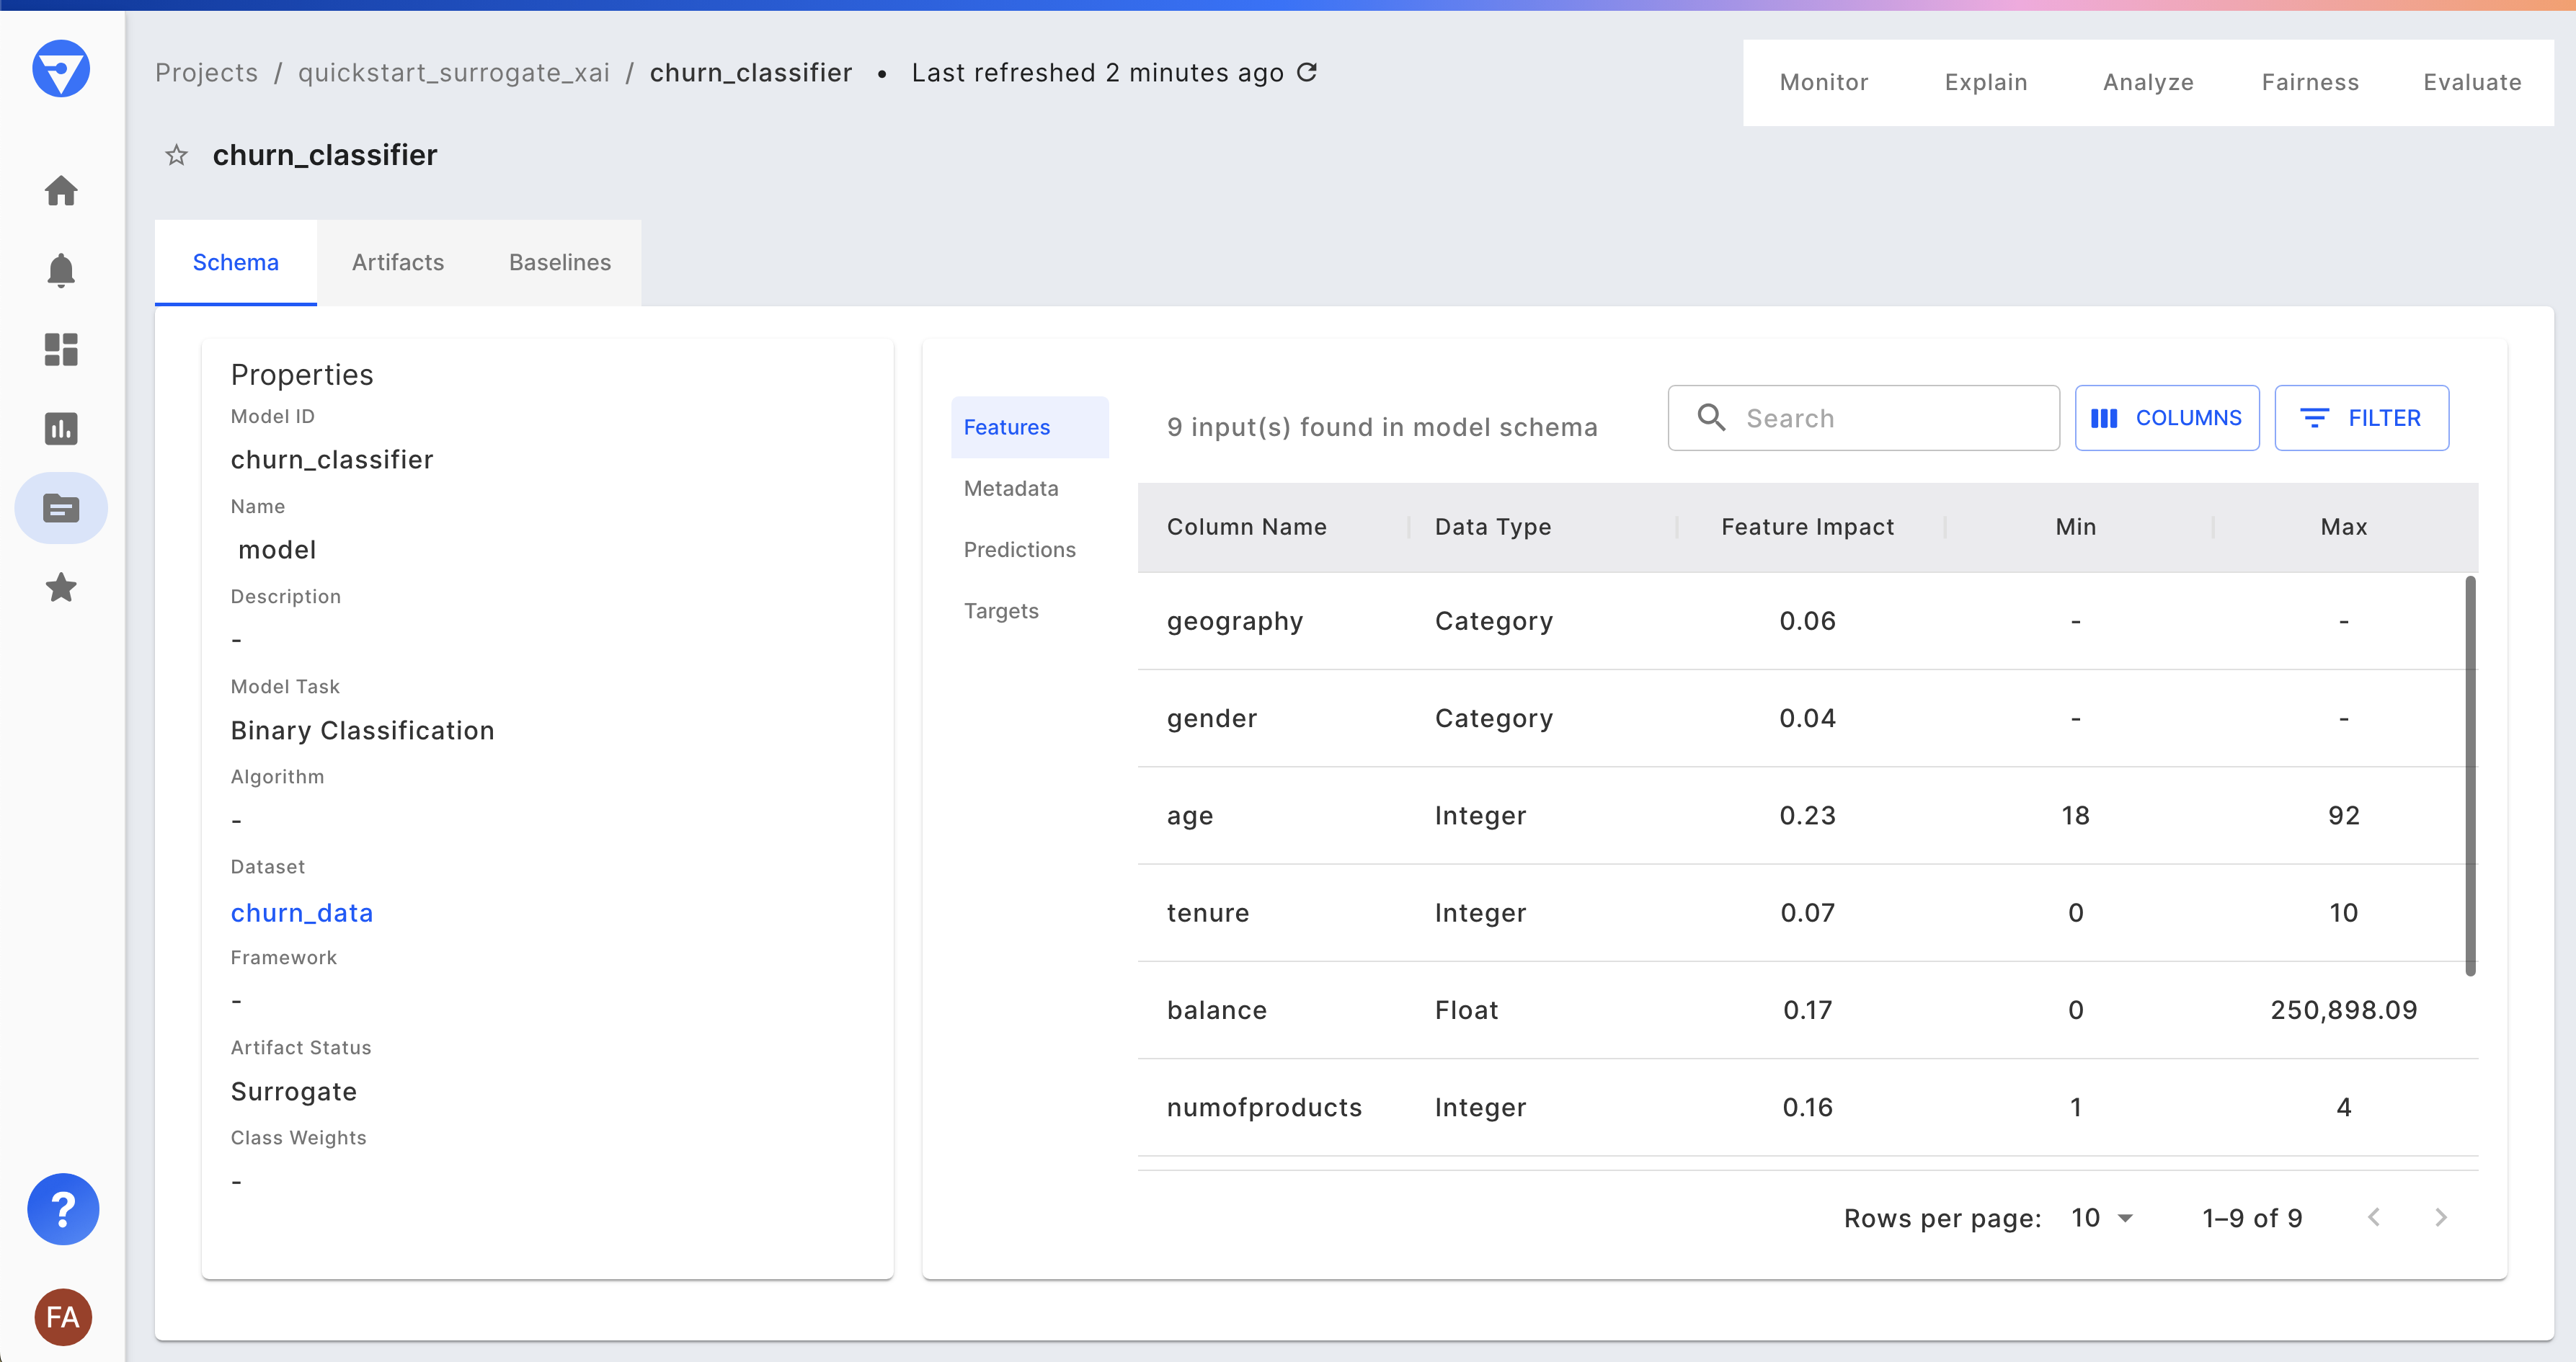

## 5. Publish Production Events

In [ ]:
PATH_TO_EVENTS_CSV = 'https://raw.githubusercontent.com/fiddler-labs/fiddler-examples/main/quickstart/data/churn_events.csv'

production_df = pd.read_csv(PATH_TO_EVENTS_CSV)
# Shift the timestamps of the production events to be as recent as today 
production_df['timestamp'] = production_df['timestamp'] + (int(time.time() * 1000) - production_df['timestamp'].max())

In [ ]:
client.publish_events_batch(
    project_id=PROJECT_ID,
    model_id=MODEL_ID,
    batch_source=production_df,
    timestamp_field='timestamp',
    id_field='customer_id' # Optional
)

## 6. Get insights

**You're all done!**
  
Return to your Fiddler environment to get enhanced monitoring and explainability into the surrogate model.  With a surrogate model or an uploaded model artifact, we can unlock advance observability like global and point explanations, PDP Plots, segment-level feature impacts and more.

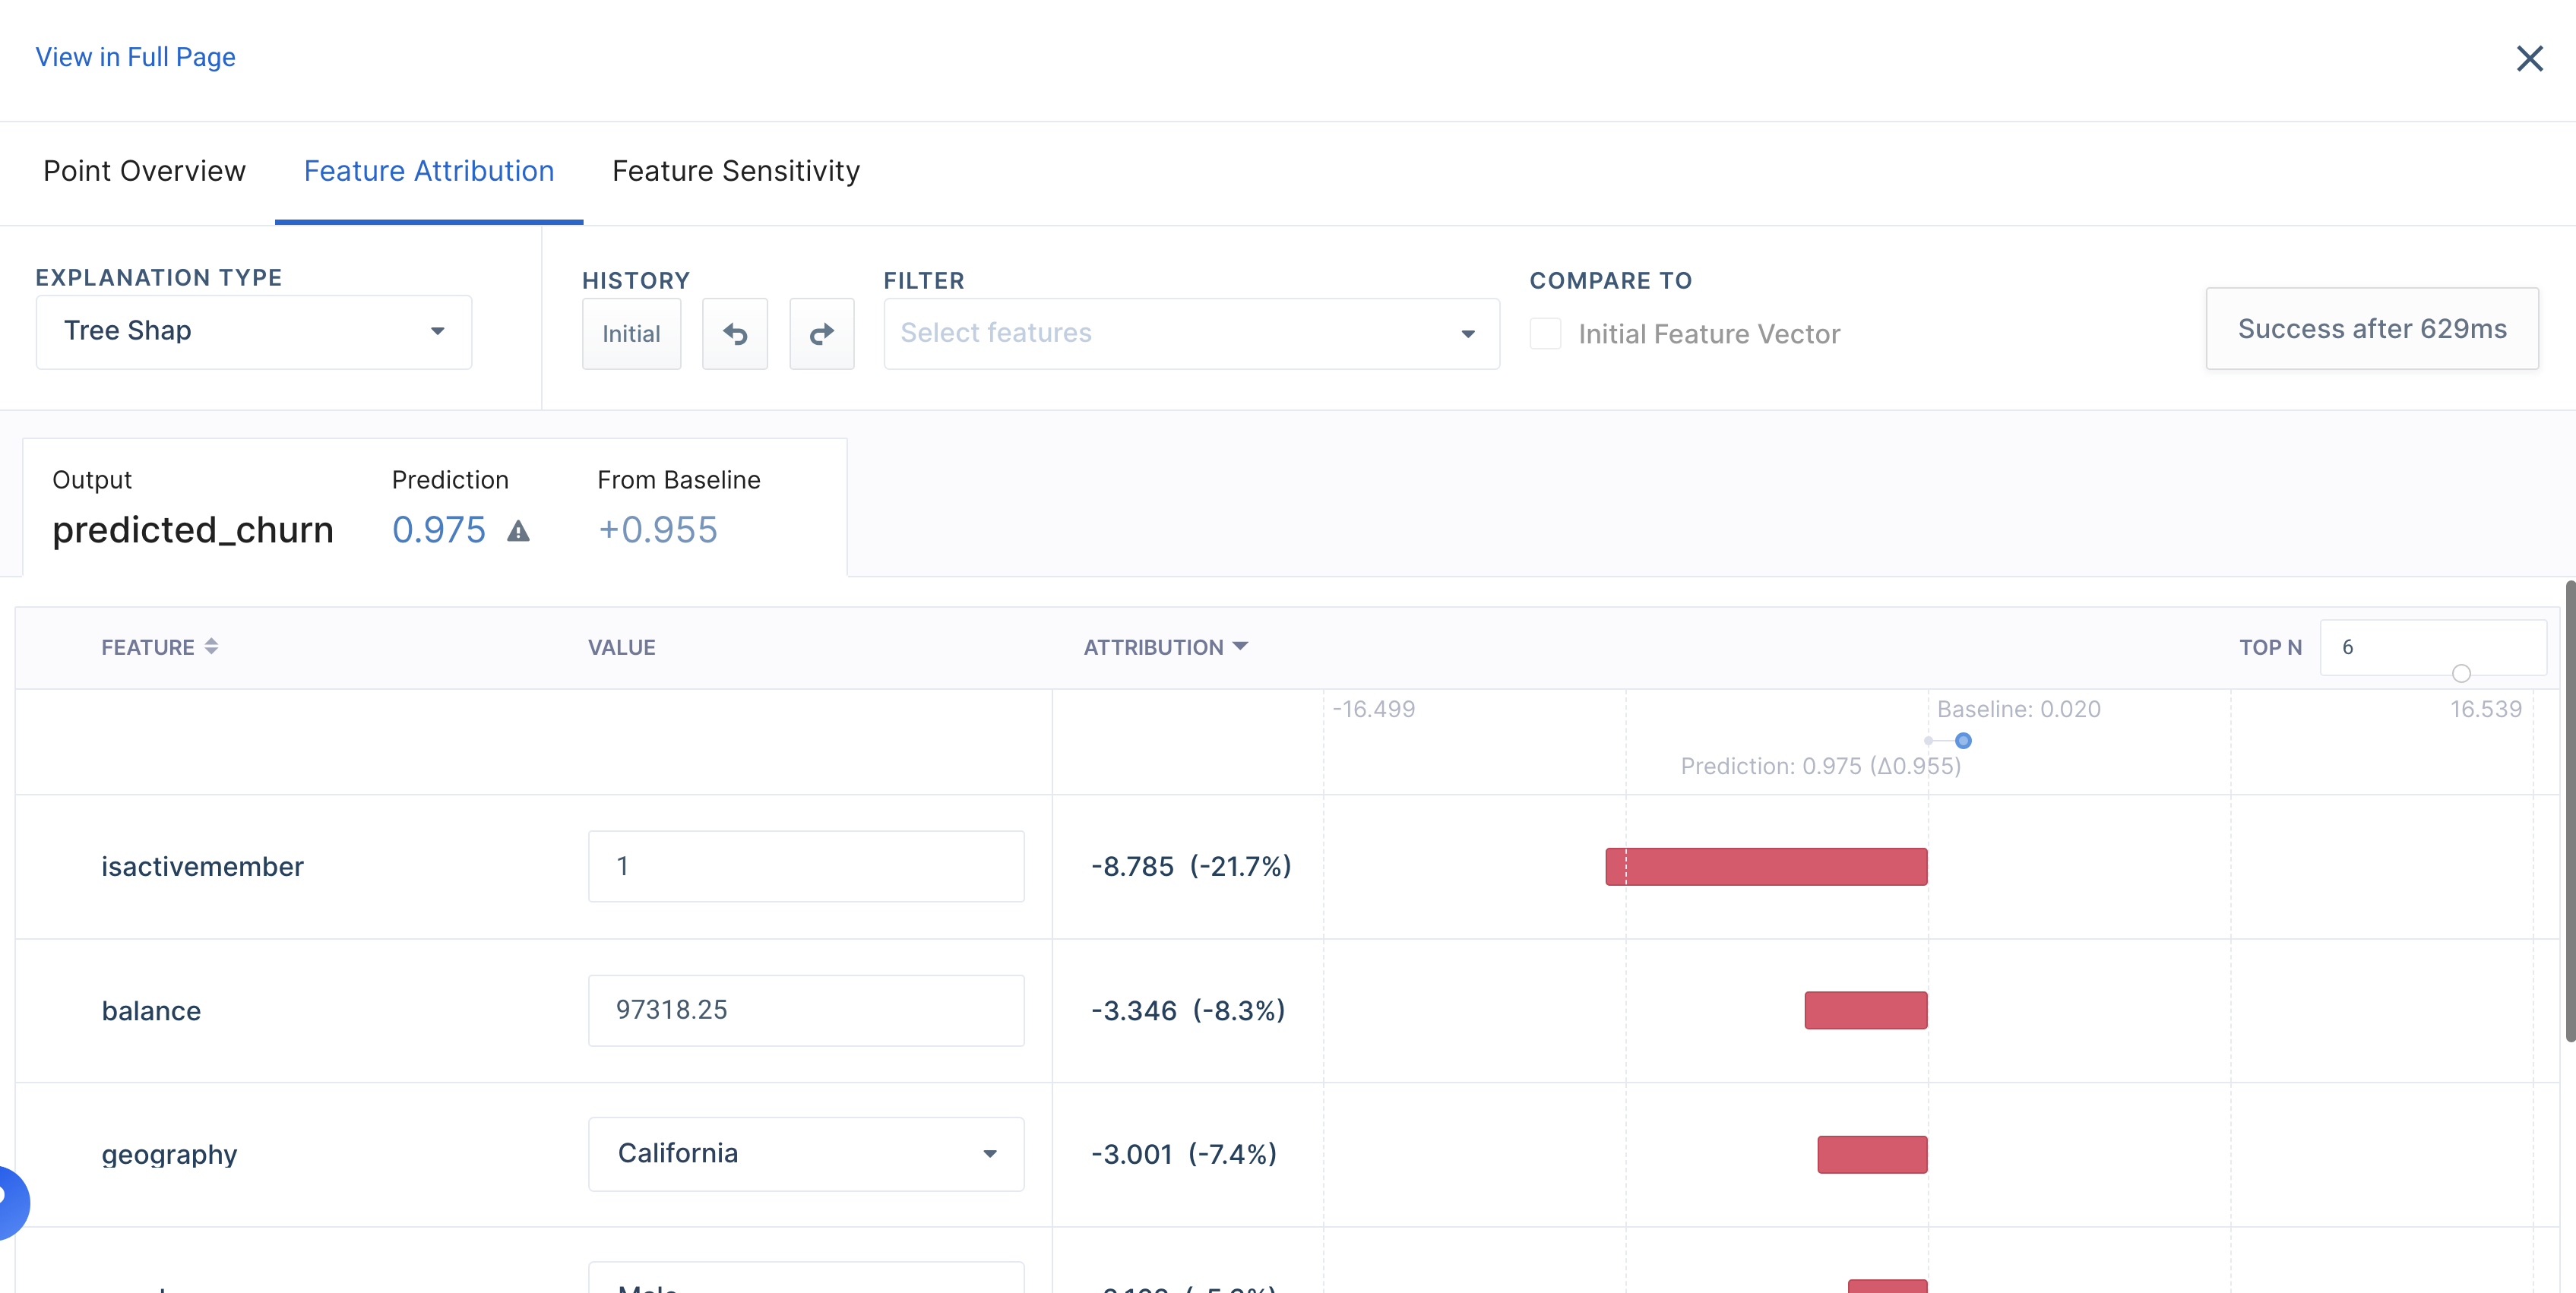

You can also run explanations and/or get feature impact now from the client...

In [ ]:
#grab a row from the baseline to run an explanation on
row = production_df.to_dict(orient='records')[0]
row

In [ ]:
explanation = client.get_explanation(
    project_id=PROJECT_ID,
    model_id=MODEL_ID,
    input_data_source=fdl.RowDataSource(row=row),
    ref_data_source=fdl.DatasetDataSource(dataset_name=DATASET_ID, num_samples=300),
    explanation_type='FIDDLER_SHAP'
)
explanation

In [ ]:
feature_impact = client.get_feature_impact(
    project_id=PROJECT_ID,
    model_id=MODEL_ID,
    data_source=fdl.DatasetDataSource(dataset_name=DATASET_ID, num_samples=200),
    num_iterations=300,
    num_refs=200,
    ci_level=0.90,
)
feature_impact



---


**Questions?**  
  
Check out [our docs](https://docs.fiddler.ai/) for a more detailed explanation of what Fiddler has to offer.

If you're still looking for answers, fill out a ticket on [our support page](https://fiddlerlabs.zendesk.com/) and we'll get back to you shortly.